# Create 2D histogram (density map) server side

In [7]:
def query_TAP(tap_endpoint, adql_query, table_to_upload=None):
    """
    Query a TAP service (designated by its tap_endpoint)
    with a given ADQL query
    
    Query is performed synchronously
    
    Return an AstroPy Table object
    """
    import requests
    from astropy.table import Table
    from astropy.io.votable import parse_single_table
    import os
    import tempfile
    import warnings
    
    r = requests.post(tap_endpoint + '/sync', data={'query': adql_query, 'request': 'doQuery', 'lang': 'adql', 'format': 'votable', 'phase': 'run'})
    
    warnings.simplefilter("ignore")
        
    tmp_vot = tempfile.NamedTemporaryFile(delete = False)
    with open(tmp_vot.name, 'w') as h:
        for line in r.iter_lines():
            if line:
                h.write(line.decode(r.encoding)+'\n')

    table = parse_single_table(tmp_vot.name).to_table()

    # finally delete temp files
    os.unlink(tmp_vot.name)

    return table


In [22]:
endpoint = 'http://tapvizier.u-strasbg.fr/TAPVizieR/tap'
x_col = 'ra'
y_col = 'dec'
x_binsize = 5
y_binsize = 5
x_name = '%s_floor' % (x_col)
y_name = '%s_floor' % (y_col)
adql = """SELECT floor(%s/%f)*%d as %s,
                 floor(%s/%f)*%d as %s,
                 count(*) as nb
          FROM "I/337/tgas"
          GROUP BY 1,2
       """ % (x_col, x_binsize, x_binsize, x_name, y_col, y_binsize, y_binsize, y_name)
print('ADQL query: ' + adql)
result = query_TAP(endpoint, adql)
print(result)

ADQL query: SELECT floor(ra/5.000000)*5 as ra_floor,
                 floor(dec/5.000000)*5 as dec_floor,
                 count(*) as nb
          FROM "I/337/tgas"
          GROUP BY 1,2
       
ra_floor [1] dec_floor [1] nb [1]
    deg           deg            
------------ ------------- ------
         0.0         -90.0     40
         0.0         -85.0    112
         0.0         -80.0    219
         0.0         -75.0    287
         0.0         -70.0    289
         0.0         -65.0    349
         0.0         -60.0    427
         0.0         -55.0    468
         0.0         -50.0    416
         0.0         -45.0    501
         ...           ...    ...
       355.0          40.0   1190
       355.0          45.0   1626
       355.0          50.0   2045
       355.0          55.0   1753
       355.0          60.0   1447
       355.0          65.0    571
       355.0          70.0    511
       355.0          75.0    407
       355.0          80.0    203
       355.0         

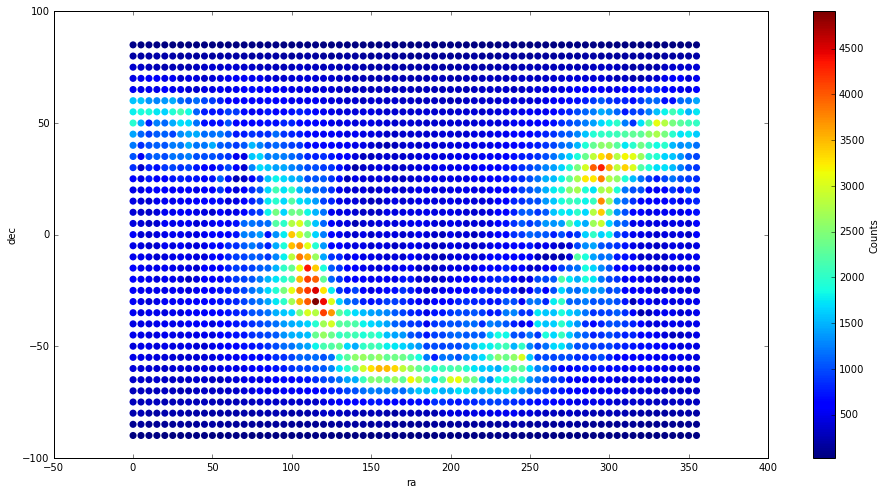

In [34]:
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt

w = 16
h = 8
fig, ax = plt.subplots(figsize = (w, h))
    
ax.set_xlabel(x_col)
ax.set_ylabel(y_col)

x, y, count = result[x_name], result[y_name], result['nb']
plt.scatter(x, y, c=count, s=50, edgecolor='')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')